In [ ]:
!pip install kornia
!pip install kornia-rs
!pip install kornia_moons
!pip install opencv-python --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /root/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt
100%|██████████| 44.2M/44.2M [00:02<00:00, 20.0MB/s]


Execution time: 18.39084243774414 seconds
Image 1 size: (600, 375)
Image 2 size: (600, 375)


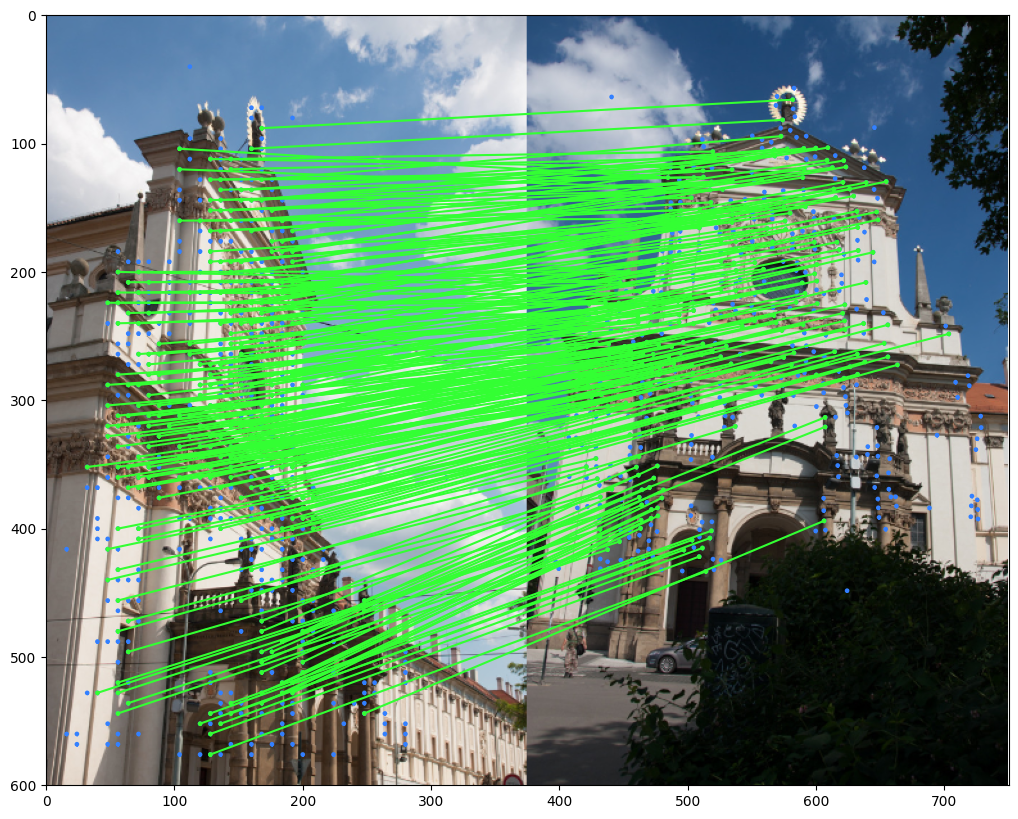

In [ ]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
from kornia_moons.viz import draw_LAF_matches

# File names
fname1 = "church1.jpg"
fname2 = "church2.jpg"

# Load and resize images
img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32)[None, ...]
img1 = K.geometry.resize(img1, (600, 375), antialias=True)
img2 = K.geometry.resize(img2, (600, 375), antialias=True)

# LoFTR matcher initialization
matcher = KF.LoFTR(pretrained="outdoor")

# Input dictionary for matcher
input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),
    "image1": K.color.rgb_to_grayscale(img2),
}

# Record the start time
start_time = time.time()

# LoFTR matching
with torch.inference_mode():
    correspondences = matcher(input_dict)

# Record the end time
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

# Extract keypoints
mkpts0 = correspondences["keypoints0"].cpu().numpy()
mkpts1 = correspondences["keypoints1"].cpu().numpy()

# Find fundamental matrix
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

# Display the images with inlier matches
draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0).view(1, -1, 2),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1).view(1, -1, 2),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": None, "feature_color": (0.2, 0.5, 1), "vertical": False},
)

# Display image sizes
img1_size = img1.shape[2], img1.shape[3]
img2_size = img2.shape[2], img2.shape[3]
print(f"Image 1 size: {img1_size}")
print(f"Image 2 size: {img2_size}")

# Show the plots
plt.show()


Execution time: 1.2386584281921387 seconds


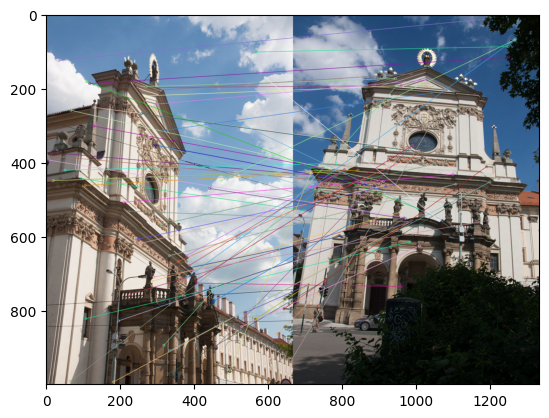

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time

# Load images
img1 = cv.imread('church1.jpg')
img2 = cv.imread('church2.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Initiate SIFT detector
sift = cv.SIFT_create()

# Record the start time
start_time = time.time()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])

# Record the end time
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

# Draw matches
img3 = cv.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the result
plt.imshow(img3)
plt.show()